# Label and feature engineering

This lab is *optional*. It demonstrates advanced SQL queries for time-series engineering. For real-world problems, this type of feature engineering code is essential. If you are pursuing a time-series project for open project week, feel free to use this code as a template. 

---

Learning objectives:

1. Learn how to use BigQuery to build time-series features and labels for forecasting
2. Learn how to visualize and explore features.
3. Learn effective scaling and normalizing techniques to improve our modeling results

Now that we have explored the data, let's start building our features, so we can build a model.

<h3><font color="#4885ed">Feature Engineering</font> </h3>

Use the `price_history` table, we can look at past performance of a given stock, to try to predict it's future stock price. In this notebook we will be focused on cleaning and creating features from this table. 

There are typically two different approaches to creating features with time-series data. 

**One approach** is aggregate the time-series into "static" features, such as "min_price_over_past_month" or "exp_moving_avg_past_30_days". Using this approach, we can use a deep neural network or a more "traditional" ML model to train. Notice we have essentially removed all sequention information after aggregating. This assumption can work well in practice. 

A **second approach** is to preserve the ordered nature of the data and use a sequential model, such as a recurrent neural network. This approach has a nice benefit that is typically requires less feature engineering. Although, training sequentially models typically takes longer.

In this notebook, we will build features and also create rolling windows of the ordered time-series data.

<h3><font color="#4885ed">Label Engineering</font> </h3>

We are trying to predict if the stock will go up or down. In order to do this we will need to "engineer" our label by looking into the future and using that as the label. We will be using the [`LAG`](https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators#lag) function in BigQuery to do this. Visually this looks like:

![](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/blogs/gcp_forecasting/rolling_window.gif?raw=true)

## Import libraries; setup

In [1]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]

In [2]:
import pandas as pd
from google.cloud import bigquery
from IPython import get_ipython
from IPython.core.magic import register_cell_magic

bq = bigquery.Client(project=PROJECT)

In [3]:
# Allow you to easily have Python variables in SQL query.
@register_cell_magic("with_globals")
def with_globals(line, cell):
    contents = cell.format(**globals())
    if "print" in line:
        print(contents)
    get_ipython().run_cell(contents)

In [4]:
def create_dataset():
    dataset = bigquery.Dataset(bq.dataset("stock_market"))
    try:
        bq.create_dataset(dataset)  # Will fail if dataset already exists.
        print("Dataset created")
    except:
        print("Dataset already exists")


create_dataset()

Dataset created


## Create time-series features and determine label based on market movement

### Summary of base tables

**TODO**: How many rows are in our base tables `price_history` and `snp500`?

In [5]:
%%with_globals
%%bigquery --project {PROJECT}
--# TODO
SELECT COUNT(*) as cnt
FROM `stock_src.price_history`

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.99s/rows]


,cnt
0,14765848


In [7]:
%%with_globals
%%bigquery --project {PROJECT}
--# TODO
SELECT COUNT(*) as cnt
FROM `stock_src.snp500`

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.30s/rows]


,cnt
0,1000


### Label engineering

Ultimately, we need to end up with a single label for each day. The label takes on 3 values: {`down`, `stay`, `up`}, where `down` and `up` indicates the normalized price (more on this below) went down 1% or more and up 1% or more, respectively. `stay` indicates the stock remained within 1%.

The steps are:

1. Compare close price and open price
2. Compute price features using analytics functions
3. Compute normalized price change (%)
4. Join with S&P 500 table
5. Create labels (`up`, `down`, `stay`)


<h3><font color="#4885ed">Compare close price and open price</font> </h3>

For each row, get the close price of yesterday and the open price of tomorrow using the [`LAG`](https://cloud.google.com/bigquery/docs/reference/legacy-sql#lag) function. We will determine tomorrow's close - today's close.

#### Shift to get tomorrow's close price.

**Learning objective 1**

In [8]:
%%with_globals print
%%bigquery df --project {PROJECT}
CREATE OR REPLACE TABLE `stock_market.price_history_delta`
AS
(
WITH shifted_price AS
  (
  SELECT *,
  (LAG(close, 1) OVER (PARTITION BY symbol order by Date DESC)) AS tomorrow_close
  FROM `stock_src.price_history`
  WHERE Close > 0
  )
SELECT a.*,
(tomorrow_close - Close) AS tomo_close_m_close
FROM shifted_price a
)

Query complete after 0.00s: 100%|██████████| 6/6 [00:00<00:00, 2455.68query/s]                        


In [9]:
%%with_globals
%%bigquery --project {PROJECT}
SELECT *
FROM stock_market.price_history_delta
ORDER by Date
LIMIT 100

Downloading: 100%|██████████| 100/100 [00:01<00:00, 73.96rows/s] 


,symbol,Date,Open,Close,tomorrow_close,tomo_close_m_close
0,djia,1928-10-01,239.43,240.01,238.14,-1.87
1,djia,1928-10-01,239.43,240.01,240.01,0.00
2,djia,1928-10-02,240.01,238.14,238.14,0.00
3,djia,1928-10-02,240.01,238.14,237.75,-0.39
4,djia,1928-10-03,238.14,237.75,240.00,2.25
...,...,...,...,...,...,...
95,djia,1928-12-10,257.33,263.95,269.34,5.39
96,djia,1928-12-11,263.95,269.34,269.34,0.00
97,djia,1928-12-11,263.95,269.34,266.82,-2.52
98,djia,1928-12-12,269.34,266.82,266.82,0.00


**TODO**: Historically, we know that the stock market has been going up. Can you think of a way to verify this using our newly created table `price_history_delta`?

**Learning objective 2**

In [10]:
%%with_globals print
%%bigquery --project {PROJECT}
SELECT
--# TODO: verify the stock market is going up -- on average.
AVG(close) AS avg_close,
AVG(tomorrow_close) AS avg_tomo_close,
AVG(tomorrow_close) - AVG(close) AS avg_change,
COUNT(*) cnt
FROM
stock_market.price_history_delta

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.95s/rows]


,avg_close,avg_tomo_close,avg_change,cnt
0,44.74092,44.743202,0.002282,14765840


### Add time series features

<h3><font color="#4885ed">Compute price features using analytics functions</font> </h3>

In addition, we will also build time-series features using the min, max, mean, and std (can you think of any over functions to use?). To do this, let's use [analytic functions]() in BigQuery (also known as window functions). 
```
An analytic function is a function that computes aggregate values over a group of rows. Unlike aggregate functions, which return a single aggregate value for a group of rows, analytic functions return a single value for each row by computing the function over a group of input rows.
```
 Using the `AVG` analytic function, we can compute the average close price of a given symbol over the past week (5 business days):
```python
 (AVG(close) OVER (PARTITION BY symbol
  ORDER BY Date
  ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING)) / close
  AS close_avg_prior_5_days
```

**Learning objective 1**

**TODO**: Please fill in the `# TODO`s in the below query

In [13]:
def get_window_fxn(agg_fxn, n_days):
    """Generate a time-series feature.

    E.g., Compute the average of the price over the past 5 days."""
    SCALE_VALUE = "close"
    sql = """
    ({agg_fxn}(close) OVER (PARTITION BY symbol
                      ORDER BY Date
                      ROWS BETWEEN {n_days} PRECEDING AND 1 PRECEDING))/{scale}
                      AS close_{agg_fxn}_prior_{n_days}_days""".format(
        agg_fxn=agg_fxn, n_days=n_days, scale=SCALE_VALUE
    )
    return sql


WEEK = 5
MONTH = 20
YEAR = 52 * 5

agg_funcs = ("MIN", "MAX", "AVG", "STDDEV")
lookbacks = (WEEK, MONTH, YEAR)
sqls = []

for fxn in agg_funcs:
    for lookback in lookbacks:
        sqls.append(get_window_fxn(fxn, lookback))
time_series_features_sql = ",".join(sqls)  # SQL string.


def preview_query():
    print(time_series_features_sql[0:1000])


preview_query()


    (MIN(close) OVER (PARTITION BY symbol
                      ORDER BY Date
                      ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING))/close
                      AS close_MIN_prior_5_days,
    (MIN(close) OVER (PARTITION BY symbol
                      ORDER BY Date
                      ROWS BETWEEN 20 PRECEDING AND 1 PRECEDING))/close
                      AS close_MIN_prior_20_days,
    (MIN(close) OVER (PARTITION BY symbol
                      ORDER BY Date
                      ROWS BETWEEN 260 PRECEDING AND 1 PRECEDING))/close
                      AS close_MIN_prior_260_days,
    (MAX(close) OVER (PARTITION BY symbol
                      ORDER BY Date
                      ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING))/close
                      AS close_MAX_prior_5_days,
    (MAX(close) OVER (PARTITION BY symbol
                      ORDER BY Date
                      ROWS BETWEEN 20 PRECEDING AND 1 PRECEDING))/close
                      AS close_MAX_prior_20_days,
 

In [14]:
%%with_globals print
%%bigquery --project {PROJECT}
CREATE OR REPLACE TABLE stock_market.price_features_delta
AS
SELECT * 
FROM 
    (SELECT *,
    {time_series_features_sql},
    -- Also get the raw time-series values; will be useful for the RNN model.
    (ARRAY_AGG(close) OVER (PARTITION BY symbol
                    ORDER BY Date
                    ROWS BETWEEN 260 PRECEDING AND 1 PRECEDING))
                    AS close_values_prior_260,
    ROW_NUMBER() OVER (PARTITION BY symbol ORDER BY Date) AS days_on_market
    FROM stock_market.price_history_delta)
WHERE days_on_market > {YEAR}

Query complete after 0.00s: 100%|██████████| 7/7 [00:00<00:00, 2378.49query/s]                        


""


In [15]:
%%bigquery --project {PROJECT}
SELECT *
FROM stock_market.price_features_delta 
ORDER BY symbol, Date
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.02rows/s]


,symbol,Date,Open,Close,tomorrow_close,tomo_close_m_close,close_MIN_prior_5_days,close_MIN_prior_20_days,close_MIN_prior_260_days,close_MAX_prior_5_days,close_MAX_prior_20_days,close_MAX_prior_260_days,close_AVG_prior_5_days,close_AVG_prior_20_days,close_AVG_prior_260_days,close_STDDEV_prior_5_days,close_STDDEV_prior_20_days,close_STDDEV_prior_260_days,close_values_prior_260,days_on_market
0,A,2000-05-25,59.25,68.75,68.75,0.00,0.843636,0.843636,0.581818,0.907345,1.317236,2.312727,0.862196,1.074633,1.183438,0.026266,0.175800,0.394621,"[44.0, 44.0, 40.38, 40.38, 44.0, 44.0, 40.0, 4...",261
1,A,2000-05-25,59.25,68.75,65.00,-3.75,0.843636,0.843636,0.581818,1.000000,1.317236,2.312727,0.880727,1.068953,1.184823,0.067071,0.176309,0.393336,"[44.0, 40.38, 40.38, 44.0, 44.0, 40.0, 40.0, 4...",262
2,A,2000-05-26,67.00,65.00,65.00,0.00,0.907692,0.892308,0.615385,1.057692,1.393231,2.446154,0.986154,1.104954,1.256099,0.075398,0.177518,0.413088,"[40.38, 44.0, 44.0, 40.0, 40.0, 41.06, 41.06, ...",264
3,A,2000-05-26,67.00,65.00,75.37,10.37,0.892308,0.892308,0.615385,1.057692,1.393231,2.446154,0.964615,1.124615,1.254643,0.085199,0.186815,0.414660,"[40.38, 40.38, 44.0, 44.0, 40.0, 40.0, 41.06, ...",263
4,A,2000-05-30,66.19,75.37,75.37,0.00,0.782805,0.769537,0.530715,0.912167,1.174207,2.109593,0.866392,0.935969,1.084532,0.052937,0.142524,0.354887,"[44.0, 44.0, 40.0, 40.0, 41.06, 41.06, 41.19, ...",265
5,A,2000-05-30,66.19,75.37,73.62,-1.75,0.862412,0.769537,0.530715,1.000000,1.174207,2.109593,0.909831,0.927465,1.086133,0.056210,0.132544,0.353556,"[44.0, 40.0, 40.0, 41.06, 41.06, 41.19, 41.19,...",266
6,A,2000-05-31,74.00,73.62,73.00,-0.62,0.882912,0.787829,0.543331,1.023771,1.202119,2.159739,0.949443,0.940804,1.113590,0.070967,0.124000,0.360585,"[40.0, 40.0, 41.06, 41.06, 41.19, 41.19, 42.13...",267
7,A,2000-05-31,74.00,73.62,73.62,0.00,0.882912,0.787829,0.543331,1.023771,1.202119,2.159739,0.962673,0.930698,1.115346,0.073455,0.108898,0.358905,"[40.0, 41.06, 41.06, 41.19, 41.19, 42.13, 42.1...",268
8,A,2000-06-01,74.44,73.00,73.00,0.00,1.000000,0.794521,0.562466,1.032466,1.068493,2.178082,1.016384,0.924986,1.128273,0.015085,0.086545,0.358615,"[41.06, 41.19, 41.19, 42.13, 42.13, 42.19, 42....",270
9,A,2000-06-01,74.44,73.00,81.75,8.75,0.890411,0.794521,0.562466,1.032466,1.068493,2.178082,0.994466,0.928411,1.126590,0.059391,0.090914,0.360242,"[41.06, 41.06, 41.19, 41.19, 42.13, 42.13, 42....",269


#### Compute percentage change, then self join with prices from S&P index. 

We will also compute price change of S&P index, GSPC. We do this so we can compute the normalized percentage change.

<h3><font color="#4885ed">Compute normalized price change (%)</font> </h3>

Before we can create our labels we need to normalize the price change using the S&P 500 index. The normalization using the S&P index fund helps ensure that the future price of a stock is not due to larger market effects. Normalization helps us isolate the factors contributing to the performance of a stock_market.

 Let's use the normalization scheme from by subtracting the scaled difference in the S&P 500 index during the same time period.
 
 In Python: 
```python
# Example calculation.
scaled_change = (50.59 - 50.69) / 50.69
scaled_s_p = (939.38 - 930.09) / 930.09
normalized_change = scaled_change - scaled_s_p
assert normalized_change == ~1.2%
```

In [16]:
scaled_change = (50.59 - 50.69) / 50.69
scaled_s_p = (939.38 - 930.09) / 930.09
normalized_change = scaled_change - scaled_s_p
print(
    """
scaled change: {:2.3f}
scaled_s_p: {:2.3f}
normalized_change: {:2.3f}
""".format(
        scaled_change, scaled_s_p, normalized_change
    )
)


scaled change: -0.002
scaled_s_p: 0.010
normalized_change: -0.012



### Compute normalized price change (shown above).

Let's join scaled price change (tomorrow_close / close) with the [gspc](https://en.wikipedia.org/wiki/S%26P_500_Index) symbol (symbol for the S&P index). Then we can normalize using the scheme described above.

**Learning objective 3**

**TODO**: Please fill in the `# TODO` in the code below.

In [17]:
snp500_index = "gspc"

In [18]:
%%with_globals print
%%bigquery --project {PROJECT}
CREATE OR REPLACE TABLE stock_market.price_features_norm_per_change
AS
WITH 
all_percent_changes AS
    (
    SELECT *, (tomo_close_m_close / Close) AS scaled_change
    FROM `stock_market.price_features_delta`
    ),
s_p_changes AS
    (SELECT
     scaled_change AS s_p_scaled_change,
     date
     FROM all_percent_changes
     WHERE symbol="{snp500_index}")

SELECT all_percent_changes.*,
       s_p_scaled_change,
       (
           # TODO
           scaled_change - s_p_scaled_change
       ) AS normalized_change          
FROM 
    all_percent_changes LEFT JOIN s_p_changes
    --# Add S&P change to all rows
    ON all_percent_changes.date = s_p_changes.date

Query complete after 0.00s: 100%|██████████| 4/4 [00:00<00:00, 1647.25query/s]                        


""


#### Verify results

In [19]:
%%with_globals print
%%bigquery df --project {PROJECT}
SELECT *
FROM stock_market.price_features_norm_per_change
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.54rows/s]


In [20]:
df.head()

,symbol,Date,Open,Close,tomorrow_close,tomo_close_m_close,close_MIN_prior_5_days,close_MIN_prior_20_days,close_MIN_prior_260_days,close_MAX_prior_5_days,...,close_AVG_prior_20_days,close_AVG_prior_260_days,close_STDDEV_prior_5_days,close_STDDEV_prior_20_days,close_STDDEV_prior_260_days,close_values_prior_260,days_on_market,scaled_change,s_p_scaled_change,normalized_change
0,BMS,2013-02-01,36.29,36.34,NaN,NaN,0.981838,0.977711,0.824436,0.988442,...,0.984260,0.892941,0.002696,0.002939,0.045424,"[30.54, 30.54, 30.75, 30.75, 30.9, 30.9, 30.8,...",14277,NaN,0.000000,NaN
1,BFS,2013-02-01,42.74,43.37,NaN,NaN,0.985704,0.985704,0.935900,1.014987,...,1.000323,0.994443,0.012045,0.008814,0.030202,"[41.12, 41.12, 41.03, 41.03, 42.11, 42.11, 42....",671,NaN,-0.011539,NaN
2,HBAN,2013-02-01,7.02,7.08,NaN,NaN,0.973164,0.973164,0.833333,0.984463,...,0.985734,0.924815,0.004790,0.007402,0.046781,"[6.28, 6.28, 6.41, 6.41, 6.4, 6.4, 6.31, 6.31,...",11509,NaN,-0.011539,NaN
3,CA,2013-02-01,24.94,25.03,NaN,NaN,0.991610,0.967639,0.869756,1.000000,...,0.993028,0.968318,0.003488,0.009700,0.068597,"[25.67, 26.31, 26.31, 24.43, 24.43, 24.25, 24....",14314,NaN,0.000000,NaN
4,EXC,2013-02-01,31.49,31.03,NaN,NaN,1.007090,0.966484,0.920722,1.013213,...,0.990880,1.081665,0.003069,0.017284,0.112686,"[38.5, 38.5, 38.98, 38.98, 39.37, 39.37, 39.49...",16693,NaN,-0.011539,NaN


<h3><font color="#4885ed">Join with S&P 500 table and Create labels: {`up`, `down`, `stay`}</font> </h3>

Join the table with the list of S&P 500. This will allow us to limit our analysis to S&P 500 companies only.

Finally we can create labels. The following SQL statement should do:

```sql
  CASE WHEN normalized_change < -0.01 THEN 'DOWN'
       WHEN normalized_change > 0.01 THEN 'UP'
       ELSE 'STAY'
  END
 ```

**Learning objective 1**

In [21]:
down_thresh = -0.01
up_thresh = 0.01

**TODO**: Please fill in the `CASE` function below.

In [22]:
%%with_globals print
%%bigquery df --project {PROJECT}
CREATE OR REPLACE TABLE stock_market.percent_change_sp500
AS
SELECT *,
    CASE  WHEN normalized_change < {down_thresh} THEN 'DOWN'
       WHEN normalized_change > {up_thresh} THEN 'UP'
       ELSE 'STAY'
    --# TODO
    END AS direction
FROM stock_market.price_features_norm_per_change features
INNER JOIN `stock_src.snp500`
USING (symbol)

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1131.66query/s]                        


In [23]:
%%with_globals print
%%bigquery --project {PROJECT}
SELECT direction, COUNT(*) as cnt
FROM stock_market.percent_change_sp500
GROUP BY direction

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.25rows/s]


,direction,cnt
0,UP,3563854
1,STAY,15533336
2,DOWN,3523770


In [24]:
%%with_globals print
%%bigquery df --project {PROJECT}
SELECT *
FROM stock_market.percent_change_sp500
LIMIT 20

Downloading: 100%|██████████| 20/20 [00:01<00:00, 14.98rows/s]


In [25]:
df.columns

Index(['symbol', 'Date', 'Open', 'Close', 'tomorrow_close',
       'tomo_close_m_close', 'close_MIN_prior_5_days',
       'close_MIN_prior_20_days', 'close_MIN_prior_260_days',
       'close_MAX_prior_5_days', 'close_MAX_prior_20_days',
       'close_MAX_prior_260_days', 'close_AVG_prior_5_days',
       'close_AVG_prior_20_days', 'close_AVG_prior_260_days',
       'close_STDDEV_prior_5_days', 'close_STDDEV_prior_20_days',
       'close_STDDEV_prior_260_days', 'close_values_prior_260',
       'days_on_market', 'scaled_change', 's_p_scaled_change',
       'normalized_change', 'company', 'industry', 'direction'],
      dtype='object')

The dataset is still quite large and the majority of the days the market `STAY`s. Let's focus our analysis on dates where [earnings per share](https://en.wikipedia.org/wiki/Earnings_per_share) (EPS) information is released by the companies. The EPS data has 3 key columns surprise, reported_EPS, and consensus_EPS: 

In [26]:
%%with_globals print
%%bigquery --project {PROJECT}
SELECT *
FROM `stock_src.eps`
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  8.16rows/s]


,date,company,symbol,surprise,reported_EPS,consensus_EPS
0,2005-08-15,AGILENT TECH INC,A,7.69,0.28,0.26
1,2007-05-14,AGILENT TECH INC,A,-2.27,0.43,0.44
2,2008-02-13,AGILENT TECH INC,A,2.44,0.42,0.41
3,2009-08-17,AGILENT TECH INC,A,36.36,0.15,0.11
4,2008-07-01,AGILENT TECH INC,A,-17.95,0.32,0.39
5,2004-11-11,AGILENT TECH INC,A,-3.23,0.30,0.31
6,2005-02-14,AGILENT TECH INC,A,5.26,0.20,0.19
7,2004-08-12,AGILENT TECH INC,A,7.14,0.30,0.28
8,2009-02-17,AGILENT TECH INC,A,-28.57,0.20,0.28
9,2007-02-15,AGILENT TECH INC,A,0.00,0.39,0.39


The surprise column indicates the difference between the expected (consensus expected eps by analysts) and the reported eps. We can join this table with our derived table to focus our analysis during earnings periods:

In [27]:
%%with_globals print
%%bigquery --project {PROJECT}
CREATE OR REPLACE TABLE stock_market.eps_percent_change_sp500
AS
SELECT a.*, b.consensus_EPS, b.reported_EPS, b.surprise
FROM stock_market.percent_change_sp500 a
INNER JOIN `stock_src.eps` b
ON a.Date = b.date
AND a.symbol = b.symbol

Query complete after 0.00s: 100%|██████████| 4/4 [00:00<00:00, 1752.19query/s]                        


""


In [28]:
%%with_globals print
%%bigquery --project {PROJECT}
SELECT *
FROM stock_market.eps_percent_change_sp500
LIMIT 20

Downloading: 100%|██████████| 20/20 [00:01<00:00, 14.59rows/s]


,symbol,Date,Open,Close,tomorrow_close,tomo_close_m_close,close_MIN_prior_5_days,close_MIN_prior_20_days,close_MIN_prior_260_days,close_MAX_prior_5_days,...,days_on_market,scaled_change,s_p_scaled_change,normalized_change,company,industry,direction,consensus_EPS,reported_EPS,surprise
0,MMM,2007-07-26,89.62,90.05,90.05,0.00,0.995225,0.995225,0.810772,1.009106,...,18965,0.000000,0.000000,0.000000,3M Co,Industrials,STAY,1.18,1.23,4.24
1,MMM,2007-07-26,89.62,90.05,90.05,0.00,0.995225,0.995225,0.810772,1.009106,...,18965,0.000000,-0.015992,0.015992,3M Co,Industrials,UP,1.18,1.23,4.24
2,MMM,2007-07-26,89.62,90.05,90.05,0.00,0.995225,0.995225,0.810772,1.000000,...,18966,0.000000,-0.015992,0.015992,3M Co,Industrials,UP,1.18,1.23,4.24
3,MMM,2007-07-26,89.62,90.05,90.05,0.00,0.995225,0.995225,0.810772,1.000000,...,18966,0.000000,0.000000,0.000000,3M Co,Industrials,STAY,1.18,1.23,4.24
4,MMM,2007-07-26,89.62,90.05,90.05,0.00,0.995225,0.995225,0.810772,1.000000,...,18966,0.000000,0.000000,0.000000,3M Co,Industrials,STAY,1.18,1.23,4.24
5,MMM,2007-07-26,89.62,90.05,90.05,0.00,0.995225,0.995225,0.810772,1.000000,...,18966,0.000000,-0.015992,0.015992,3M Co,Industrials,UP,1.18,1.23,4.24
6,MMM,2010-07-22,84.73,84.75,86.17,1.42,0.958348,0.955162,0.881888,0.971091,...,20471,0.016755,0.008220,0.008535,3M Co,Industrials,STAY,1.48,1.54,4.05
7,MMM,2010-07-22,84.73,84.75,84.75,0.00,0.969794,0.955162,0.881888,1.000000,...,20472,0.000000,0.000000,0.000000,3M Co,Industrials,STAY,1.48,1.54,4.05
8,MMM,2010-07-22,84.73,84.75,84.75,0.00,0.969794,0.955162,0.881888,1.000000,...,20472,0.000000,0.008220,-0.008220,3M Co,Industrials,STAY,1.48,1.54,4.05
9,MMM,2010-07-22,84.73,84.75,84.75,0.00,0.969794,0.955162,0.881888,1.000000,...,20472,0.000000,0.008220,-0.008220,3M Co,Industrials,STAY,1.48,1.54,4.05


In [29]:
%%with_globals print
%%bigquery --project {PROJECT}
SELECT direction, COUNT(*) as cnt
FROM stock_market.eps_percent_change_sp500
GROUP BY direction

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.05rows/s]


,direction,cnt
0,STAY,150620
1,UP,53804
2,DOWN,52952


## Feature exploration

Now that we have created our recent movements of the company’s stock price, let's visualize our features. This will help us understand the data better and possibly spot errors we may have made during our calculations.

As a reminder, we calculated the scaled prices 1 week, 1 month, and 1 year before the date that we are predicting at. 

Let's write a re-usable function for aggregating our features.

**Learning objective 2**

In [30]:
def get_aggregate_stats(field, round_digit=2):
    """Run SELECT ... GROUP BY field, rounding to nearest digit."""
    df = bq.query(
        """
    SELECT {field}, COUNT(*) as cnt
    FROM
    (SELECT ROUND({field}, {round_digit}) AS {field}
    FROM stock_market.eps_percent_change_sp500) rounded_field
    GROUP BY {field}
    ORDER BY {field}""".format(
            field=field, round_digit=round_digit, PROJECT=PROJECT
        )
    ).to_dataframe()
    return df.dropna()

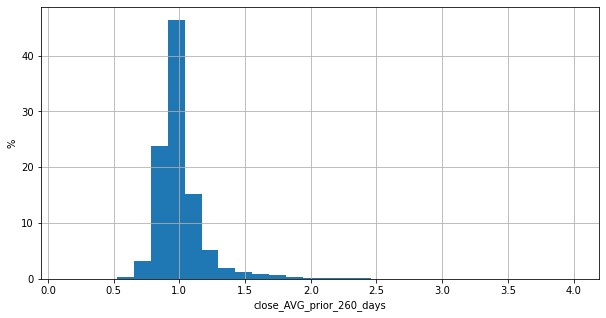

In [31]:
field = "close_AVG_prior_260_days"
CLIP_MIN, CLIP_MAX = 0.1, 4.0
df = get_aggregate_stats(field)
values = df[field].clip(CLIP_MIN, CLIP_MAX)
counts = 100 * df["cnt"] / df["cnt"].sum()  # Percentage.
ax = values.hist(weights=counts, bins=30, figsize=(10, 5))
ax.set(xlabel=field, ylabel="%");

**TODO** Use the `get_aggregate_stats` from above to visualize the `normalized_change` column.

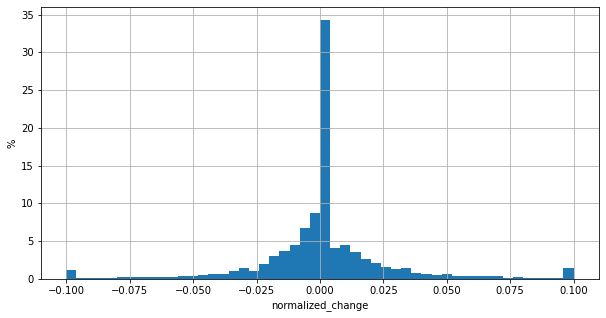

In [32]:
field = "normalized_change"
# TODO
CLIP_MIN, CLIP_MAX = -0.1, 0.1
df = get_aggregate_stats(field, round_digit=3)
values = df[field].clip(CLIP_MIN, CLIP_MAX)
counts = 100 * df["cnt"] / df["cnt"].sum()  # Percentage.
ax = values.hist(weights=counts, bins=50, figsize=(10, 5))
ax.set(xlabel=field, ylabel="%");

Let's look at results by day-of-week, month, etc.

In [33]:
VALID_GROUPBY_KEYS = (
    "DAYOFWEEK",
    "DAY",
    "DAYOFYEAR",
    "WEEK",
    "MONTH",
    "QUARTER",
    "YEAR",
)
DOW_MAPPING = {
    1: "Sun",
    2: "Mon",
    3: "Tues",
    4: "Wed",
    5: "Thur",
    6: "Fri",
    7: "Sun",
}


def groupby_datetime(groupby_key, field):
    if groupby_key not in VALID_GROUPBY_KEYS:
        raise Exception("Please use a valid groupby_key.")
    sql = """
    SELECT {groupby_key}, AVG({field}) as avg_{field}
    FROM
    (SELECT {field},
     EXTRACT({groupby_key} FROM date) AS {groupby_key}
    FROM stock_market.eps_percent_change_sp500) foo
    GROUP BY {groupby_key}
    ORDER BY {groupby_key} DESC""".format(
        groupby_key=groupby_key, field=field, PROJECT=PROJECT
    )
    print(sql)
    df = bq.query(sql).to_dataframe()
    if groupby_key == "DAYOFWEEK":
        df.DAYOFWEEK = df.DAYOFWEEK.map(DOW_MAPPING)
    return df.set_index(groupby_key).dropna()


    SELECT DAYOFWEEK, AVG(normalized_change) as avg_normalized_change
    FROM
    (SELECT normalized_change,
     EXTRACT(DAYOFWEEK FROM date) AS DAYOFWEEK
    FROM stock_market.eps_percent_change_sp500) foo
    GROUP BY DAYOFWEEK
    ORDER BY DAYOFWEEK DESC


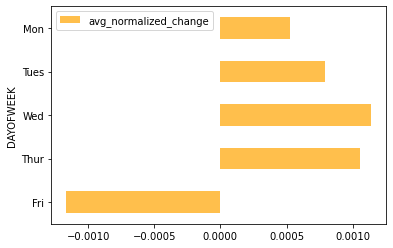

In [34]:
field = "normalized_change"

df = groupby_datetime("DAYOFWEEK", field)
ax = df.plot(kind="barh", color="orange", alpha=0.7)
ax.grid(which="major", axis="y", linewidth=0)


    SELECT DAYOFWEEK, AVG(close) as avg_close
    FROM
    (SELECT close,
     EXTRACT(DAYOFWEEK FROM date) AS DAYOFWEEK
    FROM stock_market.eps_percent_change_sp500) foo
    GROUP BY DAYOFWEEK
    ORDER BY DAYOFWEEK DESC


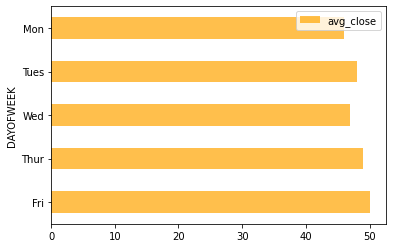

In [35]:
field = "close"
df = groupby_datetime("DAYOFWEEK", field)
ax = df.plot(kind="barh", color="orange", alpha=0.7)
ax.grid(which="major", axis="y", linewidth=0)


    SELECT MONTH, AVG(normalized_change) as avg_normalized_change
    FROM
    (SELECT normalized_change,
     EXTRACT(MONTH FROM date) AS MONTH
    FROM stock_market.eps_percent_change_sp500) foo
    GROUP BY MONTH
    ORDER BY MONTH DESC


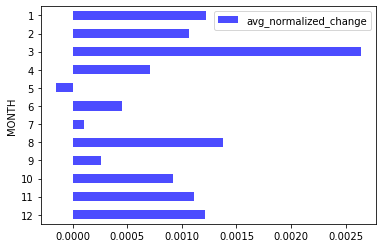

In [36]:
field = "normalized_change"
df = groupby_datetime("MONTH", field)
ax = df.plot(kind="barh", color="blue", alpha=0.7)
ax.grid(which="major", axis="y", linewidth=0)


    SELECT QUARTER, AVG(normalized_change) as avg_normalized_change
    FROM
    (SELECT normalized_change,
     EXTRACT(QUARTER FROM date) AS QUARTER
    FROM stock_market.eps_percent_change_sp500) foo
    GROUP BY QUARTER
    ORDER BY QUARTER DESC


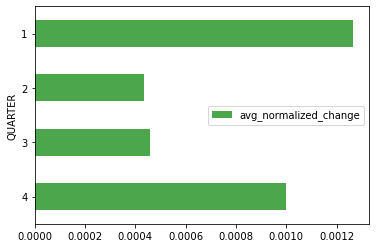

In [37]:
field = "normalized_change"
df = groupby_datetime("QUARTER", field)
ax = df.plot(kind="barh", color="green", alpha=0.7)
ax.grid(which="major", axis="y", linewidth=0)


    SELECT YEAR, AVG(close) as avg_close
    FROM
    (SELECT close,
     EXTRACT(YEAR FROM date) AS YEAR
    FROM stock_market.eps_percent_change_sp500) foo
    GROUP BY YEAR
    ORDER BY YEAR DESC


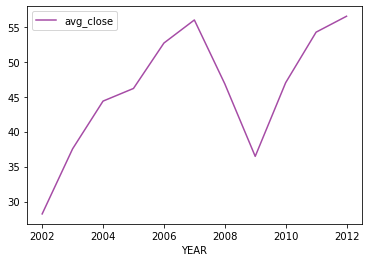

In [38]:
field = "close"
df = groupby_datetime("YEAR", field)
ax = df.plot(kind="line", color="purple", alpha=0.7)
ax.grid(which="major", axis="y", linewidth=0)


    SELECT YEAR, AVG(normalized_change) as avg_normalized_change
    FROM
    (SELECT normalized_change,
     EXTRACT(YEAR FROM date) AS YEAR
    FROM stock_market.eps_percent_change_sp500) foo
    GROUP BY YEAR
    ORDER BY YEAR DESC


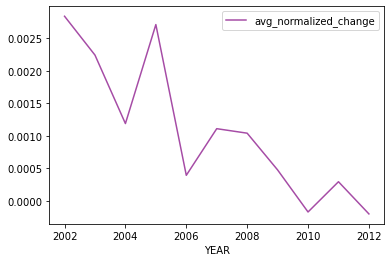

In [39]:
field = "normalized_change"
df = groupby_datetime("YEAR", field)
ax = df.plot(kind="line", color="purple", alpha=0.7)
ax.grid(which="major", axis="y", linewidth=0)

BONUS: How do our features correlate with the label `direction`? Build some visualizations. What features are most important? You can visualize this and do it statistically using the [`CORR`](https://cloud.google.com/bigquery/docs/reference/standard-sql/statistical_aggregate_functions) function.

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License